In [94]:
# %%
import sys
from pathlib import Path
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader


PROJECT_ROOT = Path.cwd().parents[1]
sys.path.append(str(PROJECT_ROOT))
print("PROJECT_ROOT =", PROJECT_ROOT)

OUTPUT_DIR = PROJECT_ROOT / "output"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
print("OUTPUT_DIR =", OUTPUT_DIR)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)


redim_model = torch.hub.load(
    "IDRnD/ReDimNet",
    "ReDimNet",
    model_name="b5",
    train_type="ptn",
    dataset="vox2",
).to(DEVICE).eval()

# Freeze the model parameters
for p in redim_model.parameters():
    p.requires_grad = False

print("Loaded ReDimNet (frozen).")


PROJECT_ROOT = /home/SpeakerRec/BioVoice/redimnet
OUTPUT_DIR = /home/SpeakerRec/BioVoice/redimnet/output
Using device: cuda


Using cache found in /home/SpeakerRec/.cache/torch/hub/IDRnD_ReDimNet_master


Loaded ReDimNet (frozen).


In [95]:
# %%
SPEAKERS = ["eden", "idan", "yoav"]
speaker_to_id = {s: i for i, s in enumerate(SPEAKERS)}
id_to_speaker = {i: s for s, i in speaker_to_id.items()}


In [96]:
# %%
TARGET_SR = 16000

@torch.no_grad()
def embed_with_redim(wav_path: str, l2_norm: bool = True):
    wav, sr = torchaudio.load(wav_path)

    if sr != TARGET_SR:
        wav = torchaudio.functional.resample(wav, sr, TARGET_SR)

    wav = wav[:1].to(DEVICE)
    emb = redim_model(wav).squeeze(0)

    if l2_norm:
        emb = emb / (emb.norm(p=2) + 1e-12)

    return emb.cpu()


In [97]:
# %%
def set_seed(seed=1234):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(1234)


In [98]:
# %%
ranking_csv = Path.cwd() / "output" / "speaker_similarity_ranking.csv"
df_rank = pd.read_csv(ranking_csv)

# Ensure correct order
df_rank = df_rank.sort_values(
    ["speaker", "cosine_to_centroid"],
    ascending=[True, False]
).reset_index(drop=True)

train_rows = []
test_rows = []

for spk in SPEAKERS:
    rows = df_rank[df_rank["speaker"] == spk]
    train_rows.append(rows.head(24))
    test_rows.append(rows.tail(6))

df_train = pd.concat(train_rows).reset_index(drop=True)
df_test  = pd.concat(test_rows).reset_index(drop=True)

print("Train samples:", len(df_train))
print("Test samples:", len(df_test))


Train samples: 72
Test samples: 18


In [99]:
# %%
def build_xy(df):
    X, y = [], []
    for r in df.itertuples():
        emb = embed_with_redim(r.path)
        X.append(emb)
        y.append(speaker_to_id[r.speaker])

    X = torch.stack(X)
    y = torch.tensor(y, dtype=torch.long)
    return X, y

X_train, y_train = build_xy(df_train)
X_test,  y_test  = build_xy(df_test)

print("X_train:", X_train.shape)
print("X_test :", X_test.shape)


X_train: torch.Size([72, 192])
X_test : torch.Size([18, 192])


In [100]:
# %%
train_loader = DataLoader(
    TensorDataset(X_train, y_train),
    batch_size=32,
    shuffle=True
)


In [101]:
# %%
class SpeakerHead(nn.Module):
    def __init__(self, in_dim=192, num_classes=3):
        super().__init__()
        self.fc = nn.Linear(in_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

head = SpeakerHead(num_classes=len(SPEAKERS)).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(
    head.parameters(), lr=1e-3, weight_decay=1e-4
)


In [ ]:
# %%
EPOCHS = 100
PATIENCE = 3
MIN_DELTA = 1e-3   # or even 5e-3


best_loss = float("inf")
best_state = None
no_improve = 0

train_loss_hist = []
train_acc_hist = []

@torch.no_grad()
def compute_accuracy(model, loader):
    model.eval()
    correct, total = 0, 0
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        preds = model(xb).argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += yb.numel()
    return correct / total


for epoch in range(1, EPOCHS + 1):
    head.train()
    running_loss = 0.0

    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)

        optimizer.zero_grad()
        loss = criterion(head(xb), yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * yb.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_loss_hist.append(train_loss)

    # ---- compute train accuracy (learning curve!) ----
    train_acc = compute_accuracy(head, train_loader)
    train_acc_hist.append(train_acc)

    # ---- early stopping on train loss ----
    if train_loss < best_loss - MIN_DELTA:
        best_loss = train_loss
        best_state = {k: v.detach().cpu().clone() for k, v in head.state_dict().items()}
        no_improve = 0
    else:
        no_improve += 1

    print(
        f"epoch {epoch:3d} | "
        f"train_loss {train_loss:.4f} | "
        f"train_acc {train_acc:.3f}"
    )

    if no_improve >= PATIENCE:
        print("Early stopping triggered.")
        break


head.load_state_dict(best_state)
head.eval()


epoch   1 | train_loss 1.1022 | train_acc 0.333
epoch   2 | train_loss 1.0831 | train_acc 0.347
epoch   3 | train_loss 1.0649 | train_acc 0.375
epoch   4 | train_loss 1.0468 | train_acc 0.486
epoch   5 | train_loss 1.0290 | train_acc 0.583
epoch   6 | train_loss 1.0114 | train_acc 0.806
epoch   7 | train_loss 0.9939 | train_acc 0.958
epoch   8 | train_loss 0.9767 | train_acc 0.972
epoch   9 | train_loss 0.9597 | train_acc 0.972
epoch  10 | train_loss 0.9430 | train_acc 1.000
epoch  11 | train_loss 0.9265 | train_acc 1.000
epoch  12 | train_loss 0.9103 | train_acc 1.000
epoch  13 | train_loss 0.8943 | train_acc 1.000
epoch  14 | train_loss 0.8786 | train_acc 1.000
epoch  15 | train_loss 0.8631 | train_acc 1.000
epoch  16 | train_loss 0.8480 | train_acc 1.000
epoch  17 | train_loss 0.8332 | train_acc 1.000
epoch  18 | train_loss 0.8184 | train_acc 1.000
epoch  19 | train_loss 0.8041 | train_acc 1.000
epoch  20 | train_loss 0.7898 | train_acc 1.000
epoch  21 | train_loss 0.7760 | train_ac

SpeakerHead(
  (fc): Linear(in_features=192, out_features=3, bias=True)
)

In [103]:
# %%
HEAD_PATH = Path.cwd() / "output" / "redim_speaker_head_linear.pt"

torch.save(
    {
        "state_dict": head.state_dict(),
        "speaker_to_id": speaker_to_id,
        "id_to_speaker": id_to_speaker,
        "l2_norm_emb": True,
        "train_samples_per_speaker": 25,
        "early_stopping": {
            "patience": PATIENCE,
            "min_delta": MIN_DELTA,
        },
    },
    HEAD_PATH
)

print("Saved speaker head to:", HEAD_PATH)


Saved speaker head to: /home/SpeakerRec/BioVoice/redimnet/output/redim_speaker_head_linear.pt


In [104]:
# %%
@torch.no_grad()
def eval_acc(model, X, y):
    logits = model(X.to(DEVICE))
    pred = logits.argmax(dim=1).cpu()
    return (pred == y).float().mean().item()

test_acc = eval_acc(head, X_test, y_test)
print("TEST accuracy:", test_acc)


TEST accuracy: 1.0


In [105]:
# %%
pred_test = head(X_test.to(DEVICE)).argmax(dim=1).cpu()

df_cm = pd.DataFrame({
    "true": [id_to_speaker[i] for i in y_test.tolist()],
    "pred": [id_to_speaker[i] for i in pred_test.tolist()]
})

cm = pd.crosstab(df_cm["true"], df_cm["pred"])
display(cm)


pred,eden,idan,yoav
true,,,
eden,6,0,0
idan,0,6,0
yoav,0,0,6


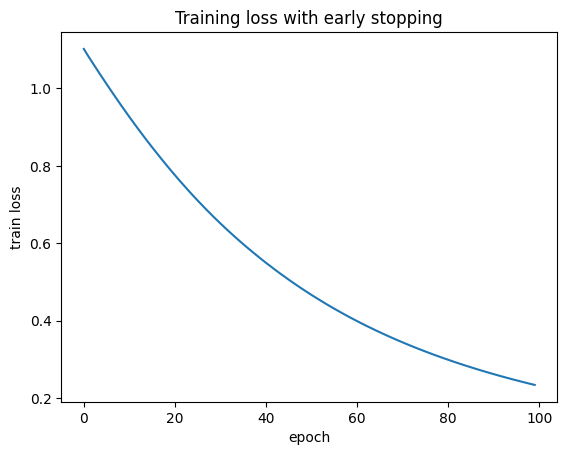

In [106]:
# %%
plt.figure()
plt.plot(train_loss_hist)
plt.xlabel("epoch")
plt.ylabel("train loss")
plt.title("Training loss with early stopping")
plt.show()


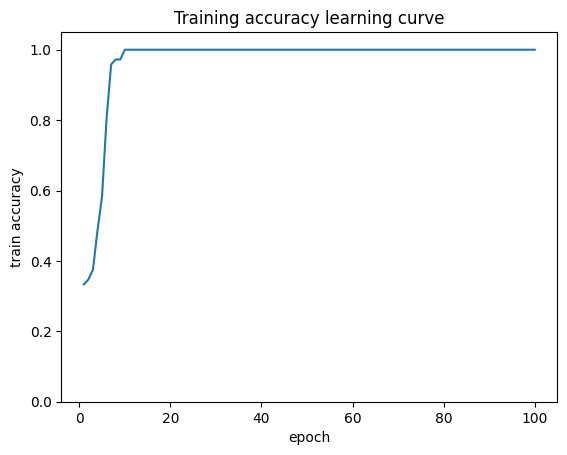

In [107]:
# %%
epochs = range(1, len(train_acc_hist) + 1)

plt.figure()
plt.plot(epochs, train_acc_hist)
plt.xlabel("epoch")
plt.ylabel("train accuracy")
plt.title("Training accuracy learning curve")
plt.ylim(0, 1.05)
plt.show()
